In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import os

import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

from torchgeo.datasets import CV4AKenyaCropType

In [2]:
ROOT_DIR = os.path.expanduser("~/mount/data/")
API_KEY = ""

## Benchmarking

In [3]:
%%time
# constructor takes ~13 seconds, not sure if this is all the MD5 check
dataset = CV4AKenyaCropType(
    ROOT_DIR,
    chip_size=256,
    stride=128,
    bands=None, # Use all bands
    download=True,
    api_key=API_KEY,
    verbose=True
)

Files already downloaded and verified
CPU times: user 11.9 s, sys: 1.9 s, total: 13.8 s
Wall time: 13.8 s


In [4]:
%%time
# First hit on a tile takes ~21 seconds when loading all bands
chip = dataset[0]

Loading all imagery for ref_african_crops_kenya_02_tile_00
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20190606
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20190701
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20190706
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20190711
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20190721
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20190805
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20190815
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20190825
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20190909
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20190919
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20190924
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20191004
Loading imagery for ref_african_crops_kenya_02_tile_00 at 20191103
Loading labels/field_ids for ref_african_crops_kenya_02_tile_00
CPU ti

In [5]:
%%time
# Second hit on a chip takes no time because we cache tile results
chip = dataset[0]

CPU times: user 23 µs, sys: 7 µs, total: 30 µs
Wall time: 31.9 µs


## Testing the train/test split

In [6]:
train_field_ids, test_field_ids = dataset.get_splits()
len(train_field_ids), len(test_field_ids)

(3361, 1436)

## Show chip access pattern across a tile

In [7]:
chip_size = 256
stride = 256

dataset = CV4AKenyaCropType(
    ROOT_DIR,
    chip_size=chip_size,
    stride=stride,
    bands=("B04","B03","B02"),
    download=True,
    api_key=API_KEY,
    verbose=False
)

Files already downloaded and verified


In [8]:
chip = dataset[0] # load tiles into cache
print(chip["metadata"])

(0, 0, 0)


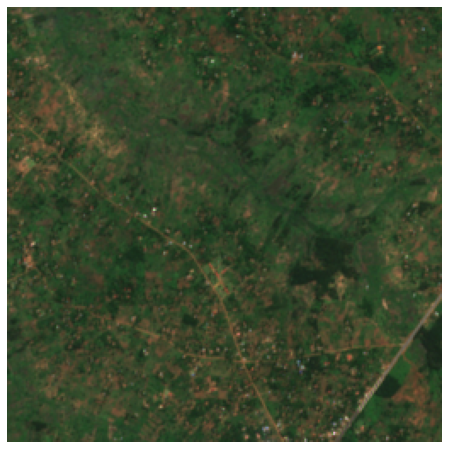

In [9]:
img = np.rollaxis(chip["img"][0,:,:,:].copy(), 0, 3) # get the image for the first date, change ordering to channels last

plt.figure(figsize=(8,8))
plt.imshow(img * 4)
plt.axis("off")
plt.show()
plt.close()

In [10]:
%%time
counts = np.zeros((dataset.tile_height, dataset.tile_width), dtype=np.int32)

i = 0
while True:
    chip = dataset[i]
    tile_index, y, x = chip["metadata"]

    if tile_index != 0:
        break
    
    counts[y:y+chip_size, x:x+chip_size] += 1
    i += 1

CPU times: user 3.22 s, sys: 1.97 s, total: 5.19 s
Wall time: 5.2 s


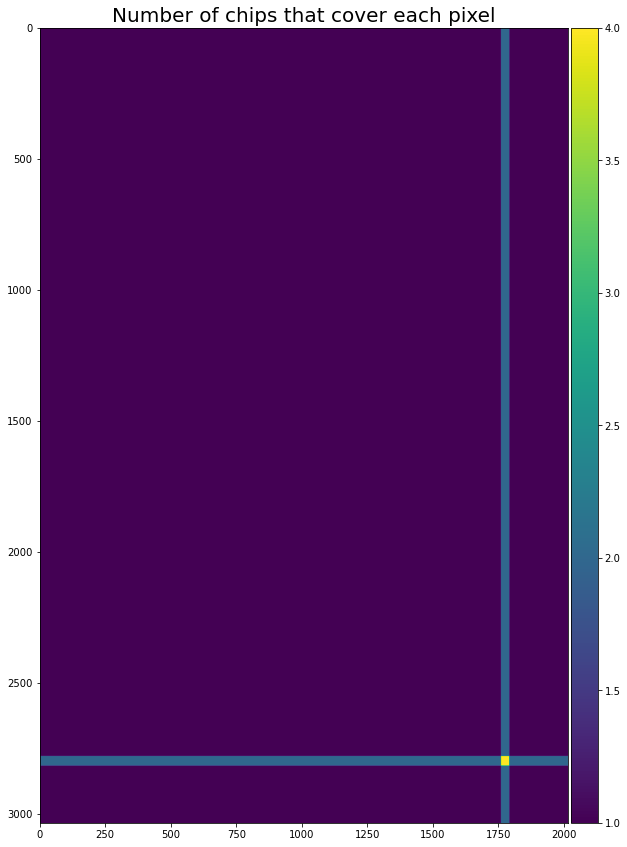

In [11]:
scale = 5
plt.figure(figsize=(dataset.tile_width // 1000 * scale, dataset.tile_height // 1000 * scale))
ax = plt.gca()
im = plt.imshow(counts)
plt.title("Number of chips that cover each pixel", fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()
plt.close()